# Предобработка датасета

Подключаем диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.impute import KNNImputer

Считываем датасет

In [ ]:
frac = pd.read_csv('/content/drive/MyDrive/frac_new_copy.csv', encoding = "windows-1251", sep=";")

Выберем фичи, оказывабщие влияние на дебит 

In [ ]:
frac = frac[[
    'year', 'h',
    'porosity', 'permeability_avg',
    'init_oil_saturation_factor', 'aps_avg',
    'sandiness', 'recoverables', 'remaining_recoverables',
    'base_qliq1', 'base_qliq3', 'cumulative_fluid_production',
    'bottomhole_pressure6', 'kprod_current',
    'previous_grp_result_qliq3', 'rate_liq_avg_1000',
    'liq_sum_1000', 'receptivity_avg_nagn1',
    'bottomhole_pressure_nagn1', 'result_qoil3',
    'kprod_current', 'bottomhole_pressure6'
]]

Выведем таблицу с процентом пропуском в каждом столбце

In [ ]:
count_nan = pd.DataFrame(round((frac.isnull().mean() * 100), 2))
count_nan[count_nan[0] > 0].sort_values(by=0)

,0
h,0.07
sandiness,0.07
result_qoil3,0.07
init_oil_saturation_factor,1.49
porosity,1.56
permeability_avg,1.56
aps_avg,5.43
receptivity_avg_nagn1,8.62
bottomhole_pressure6,52.99
bottomhole_pressure6,52.99


Удалим столбцы с процентом пропусков больше 50%

In [ ]:
frac = frac.drop(['bottomhole_pressure6', 'kprod_current', 'bottomhole_pressure_nagn1', 'kprod_current', 'bottomhole_pressure6', ], axis=1)

Заполним пропуски ближайшими соседями 

In [ ]:
imputer = KNNImputer(n_neighbors=5)
frac=pd.DataFrame(imputer.fit_transform(frac), columns = frac.columns)

# Нейросеть для регрессии

Таргет и предикторы

In [ ]:
X = frac.drop(['result_qoil3', 'year'], axis=1)
y = frac['result_qoil3']

Насплитим тренировочную, тестовую и вылидационные выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.2, random_state = 15)

Последовательная нейросеть из двух слоёв

In [ ]:
regres_model = Sequential()
regres_model.add(Dense(20,activation='softmax',input_dim=X_train.shape[1]))
regres_model.add(Dense(1, activation='sigmoid'))
regres_model.compile(optimizer='adam', loss='mse', metrics='mae')

Размеры пакетов и количество эпох

In [ ]:
batch_size = 40
epochs = 100

Обучим нейросеть

In [ ]:
regres_model_hist = regres_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 0.1611 - mae: 0.3897 - val_loss: 0.1617 - val_mae: 0.3925
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1474 - mae: 0.3721 - val_loss: 0.1480 - val_mae: 0.3749
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1348 - mae: 0.3552 - val_loss: 0.1355 - val_mae: 0.3582
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.1234 - mae: 0.3391 - val_loss: 0.1241 - val_mae: 0.3422
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1129 - mae: 0.3237 - val_loss: 0.1138 - val_mae: 0.3270
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1034 - mae: 0.3091 - val_loss: 0.1043 - val_mae: 0.3124
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0947 - mae: 0.2951 - val_loss: 0.0955 - val_mae: 0.2985
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0867 - m

Проверим на тестовой выборке и выведем критерий MSE

In [ ]:
y_pred = regres_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE: %f" % (mse))

10/10 [==============================] - 0s 2ms/step
MSE: 0.012966


График

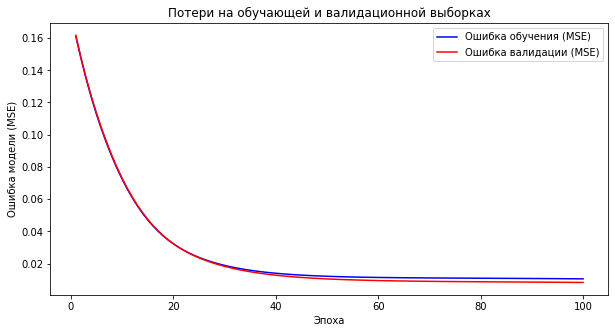

In [ ]:
loss_function = regres_model_hist.history['loss']
val_loss_function = regres_model_hist.history['val_loss']

epochs = range(1,epochs+1)

plt.figure(figsize=(10,5))
plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,loss_function,color='blue',label='Ошибка обучения (MSE)')
plt.plot(epochs,val_loss_function,color='red',label='Ошибка валидации (MSE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MSE)')
plt.legend()
plt.show()

# Sklearn

In [ ]:
import lightgbm as lgb

frac_lgb = lgb.LGBMRegressor(iterations=100, verbose=10, random_state=42)

frac_lgb.fit(X_train,y_train)

y_pred_lgbm = frac_lgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lgbm)

print("MSE: %f" % (mse))

MSE: 0.008432
